In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\nDataset: Spotify Music Data to Identify Moods (Kaggle)")
print("Fonte: https://www.kaggle.com/datasets/musicblogger/spotify-music-data-to-identify-the-moods")


Dataset: Spotify Music Data to Identify Moods (Kaggle)
Fonte: https://www.kaggle.com/datasets/musicblogger/spotify-music-data-to-identify-the-moods


In [21]:
try:
    df_spotify = pd.read_csv('data_moods.csv')
except:
    raise FileNotFoundError("Dataset não encontrado. Faça upload do data_moods.csv")

print("\n EXPLORAÇÃO INICIAL DO DATASET SPOTIFY...")

print("\n Primeiras linhas:")
print(df_spotify.head())

print("\n Informações das colunas:")
print(df_spotify.info())

print("\n Estatísticas descritivas:")
print(df_spotify.describe())

print("\n Colunas disponíveis:")
for i, col in enumerate(df_spotify.columns, 1):
    print(f"   {i}. {col}")


 EXPLORAÇÃO INICIAL DO DATASET SPOTIFY...

 Primeiras linhas:
                                          name                        album  \
0                                         1999                         1999   
1                                           23                           23   
2                                     9 Crimes                            9   
3                               99 Luftballons               99 Luftballons   
4  A Boy Brushed Red Living In Black And White  They're Only Chasing Safety   

           artist                      id release_date  popularity  length  \
0          Prince  2H7PHVdQ3mXqEHXcvclTB0   1982-10-27          68  379266   
1  Blonde Redhead  4HIwL9ii9CcXpTOTzMq0MP   2007-04-16          43  318800   
2     Damien Rice  5GZEeowhvSieFDiR8fQ2im   2006-11-06          60  217946   
3            Nena  6HA97v4wEGQ5TUClRM0XLc   1984-08-21           2  233000   
4       Underoath  47IWLfIKOKhFnz1FUEUIkE   2004-01-01          60  2680

In [22]:
print("\n MAPEANDO FEATURES MUSICAIS PARA HUMORES...")

def mapear_humor_spotify(row):
    energy = row['energy']
    valence = row['valence']
    danceability = row['danceability']
    acousticness = row['acousticness']

    if valence > 0.65 and energy > 0.5:
        return 'feliz'
    elif energy > 0.7 and danceability > 0.6:
        return 'animado'
    elif energy < 0.4 and acousticness > 0.5:
        return 'relaxado'
    elif valence < 0.35 and energy < 0.5:
        return 'triste'
    elif 0.35 <= valence <= 0.65 and acousticness > 0.6:
        return 'nostalgico'
    elif energy > 0.7 and valence < 0.5:
        return 'estressado'
    elif energy < 0.3:
        return 'cansado'
    else:
        return 'relaxado'

df_spotify['humor'] = df_spotify.apply(mapear_humor_spotify, axis=1)
print("\nDistribuição de humores identificados:")
print(df_spotify['humor'].value_counts())


 MAPEANDO FEATURES MUSICAIS PARA HUMORES...

Distribuição de humores identificados:
humor
relaxado      379
estressado     96
feliz          90
animado        58
triste         49
nostalgico     10
cansado         4
Name: count, dtype: int64


In [23]:
print("\n MAPEANDO CARACTERÍSTICAS PARA BEBIDAS...")

def mapear_bebida(row):
    humor = row['humor']
    energy = row['energy']
    valence = row['valence']
    danceability = row['danceability']

    if humor == 'feliz':
        if danceability > 0.6:
            return 'cerveja'
        else:
            return 'espumante'
    elif humor == 'animado':
        if energy > 0.8:
            return 'drink tropical'
        else:
            return 'gin tonica'
    elif humor == 'relaxado':
        if valence > 0.6:
            return 'vinho'
        else:
            return 'whisky'
    elif humor == 'triste':
        return 'whisky'
    elif humor == 'nostalgico':
        return 'vinho'
    elif humor == 'estressado':
        if energy > 0.7:
            return 'cerveja'
        else:
            return 'caipirinha'
    elif humor == 'cansado':
        return 'vinho'
    else:
        return 'cerveja'

df_spotify['bebida_favorita'] = df_spotify.apply(mapear_bebida, axis=1)
print("\nDistribuição de bebidas recomendadas:")
print(df_spotify['bebida_favorita'].value_counts())


 MAPEANDO CARACTERÍSTICAS PARA BEBIDAS...

Distribuição de bebidas recomendadas:
bebida_favorita
whisky            404
cerveja           149
drink tropical     43
vinho              38
espumante          37
gin tonica         15
Name: count, dtype: int64


In [24]:
print("\n CRIANDO VARIÁVEIS ADICIONAIS...")

def mapear_intensidade(energy):
    if energy < 0.4:
        return 'leve'
    elif energy < 0.7:
        return 'media'
    else:
        return 'forte'

df_spotify['intensidade_bebida'] = df_spotify['energy'].apply(mapear_intensidade)

def mapear_momento(row):
    dance = row['danceability']
    energy = row['energy']
    if dance > 0.7 and energy > 0.7:
        return 'festa'
    elif dance > 0.5 and energy > 0.5:
        return 'com amigos'
    elif energy < 0.4:
        return 'em casa'
    else:
        return 'jantar'

df_spotify['momento_consumo'] = df_spotify.apply(mapear_momento, axis=1)

def inferir_estilo(row):
    energy = row['energy']
    acousticness = row['acousticness']
    danceability = row['danceability']
    if acousticness > 0.7:
        return 'acustico'
    elif energy > 0.8 and danceability > 0.7:
        return 'eletronica'
    elif energy > 0.7:
        return 'rock'
    elif danceability > 0.6:
        return 'pop'
    else:
        return 'indie'

df_spotify['estilo_musical'] = df_spotify.apply(inferir_estilo, axis=1)

print(f"   - intensidade_bebida: {df_spotify['intensidade_bebida'].nunique()} categorias")
print(f"   - momento_consumo: {df_spotify['momento_consumo'].nunique()} categorias")
print(f"   - estilo_musical: {df_spotify['estilo_musical'].nunique()} categorias")


 CRIANDO VARIÁVEIS ADICIONAIS...
   - intensidade_bebida: 3 categorias
   - momento_consumo: 4 categorias
   - estilo_musical: 5 categorias


In [25]:
df_final = df_spotify[[
    'name', 'artist', 'energy', 'valence', 'danceability', 'acousticness',
    'humor', 'estilo_musical', 'bebida_favorita', 'intensidade_bebida', 'momento_consumo'
]].copy()

df_final.to_csv('drunkify_spotify_dataset.csv', index=False)

 Visualizações salvas: analise_exploratoria_spotify.png


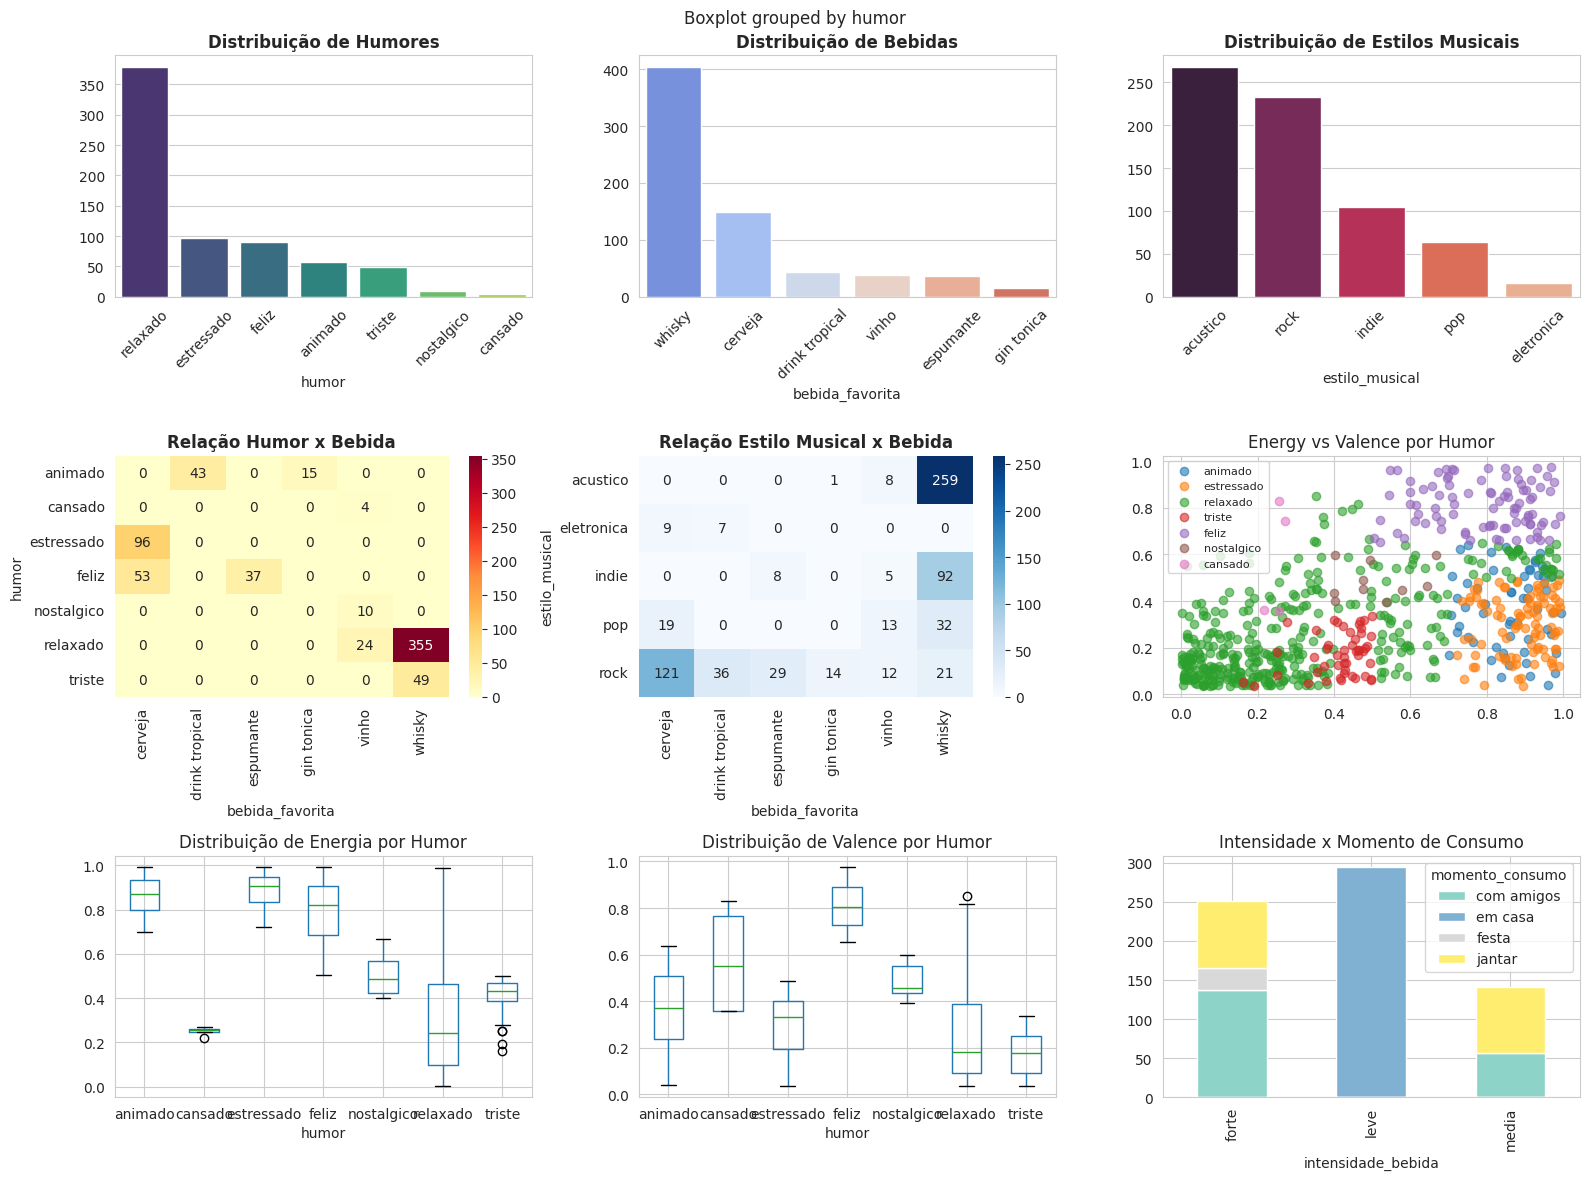

In [26]:
fig = plt.figure(figsize=(16, 12))

# 1. Distribuição de Humores
ax1 = plt.subplot(3, 3, 1)
humor_counts = df_final['humor'].value_counts()
sns.barplot(x=humor_counts.index, y=humor_counts.values, palette='viridis', ax=ax1)
ax1.set_title('Distribuição de Humores', fontweight='bold', fontsize=12)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Distribuição de Bebidas
ax2 = plt.subplot(3, 3, 2)
bebida_counts = df_final['bebida_favorita'].value_counts()
sns.barplot(x=bebida_counts.index, y=bebida_counts.values, palette='coolwarm', ax=ax2)
ax2.set_title('Distribuição de Bebidas', fontweight='bold', fontsize=12)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Distribuição de Estilos Musicais
ax3 = plt.subplot(3, 3, 3)
estilo_counts = df_final['estilo_musical'].value_counts()
sns.barplot(x=estilo_counts.index, y=estilo_counts.values, palette='rocket', ax=ax3)
ax3.set_title('Distribuição de Estilos Musicais', fontweight='bold', fontsize=12)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Heatmap: Humor x Bebida
ax4 = plt.subplot(3, 3, 4)
crosstab_humor_bebida = pd.crosstab(df_final['humor'], df_final['bebida_favorita'])
sns.heatmap(crosstab_humor_bebida, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
ax4.set_title('Relação Humor x Bebida', fontweight='bold', fontsize=12)

# 5. Heatmap: Estilo x Bebida
ax5 = plt.subplot(3, 3, 5)
crosstab_estilo_bebida = pd.crosstab(df_final['estilo_musical'], df_final['bebida_favorita'])
sns.heatmap(crosstab_estilo_bebida, annot=True, fmt='d', cmap='Blues', ax=ax5)
ax5.set_title('Relação Estilo Musical x Bebida', fontweight='bold', fontsize=12)

# 6. Scatter Energy vs Valence
ax6 = plt.subplot(3, 3, 6)
for humor in df_final['humor'].unique():
    subset = df_final[df_final['humor'] == humor]
    ax6.scatter(subset['energy'], subset['valence'], label=humor, alpha=0.6)
ax6.legend(fontsize=8)
ax6.set_title('Energy vs Valence por Humor')

# 7. Boxplot Energy x Humor
ax7 = plt.subplot(3, 3, 7)
df_final.boxplot(column='energy', by='humor', ax=ax7)
ax7.set_title('Distribuição de Energia por Humor')

# 8. Boxplot Valence x Humor
ax8 = plt.subplot(3, 3, 8)
df_final.boxplot(column='valence', by='humor', ax=ax8)
ax8.set_title('Distribuição de Valence por Humor')

# 9. Intensidade x Momento
ax9 = plt.subplot(3, 3, 9)
crosstab_intensidade = pd.crosstab(df_final['intensidade_bebida'], df_final['momento_consumo'])
crosstab_intensidade.plot(kind='bar', stacked=True, ax=ax9, colormap='Set3')
ax9.set_title('Intensidade x Momento de Consumo')

plt.tight_layout()
plt.savefig('analise_exploratoria_spotify.png', dpi=300, bbox_inches='tight')
print(" Visualizações salvas: analise_exploratoria_spotify.png")
plt.show()

In [27]:
print("\n PREPARANDO DADOS PARA MACHINE LEARNING...")

le_humor = LabelEncoder()
df_final['humor_encoded'] = le_humor.fit_transform(df_final['humor'])
le_estilo = LabelEncoder()
df_final['estilo_encoded'] = le_estilo.fit_transform(df_final['estilo_musical'])
le_bebida = LabelEncoder()
df_final['bebida_encoded'] = le_bebida.fit_transform(df_final['bebida_favorita'])

X = df_final[['humor_encoded', 'estilo_encoded', 'energy', 'valence', 'danceability', 'acousticness']]
y = df_final['bebida_encoded']

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['energy', 'valence', 'danceability', 'acousticness']] = scaler.fit_transform(
    X[['energy', 'valence', 'danceability', 'acousticness']]
)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


 PREPARANDO DADOS PARA MACHINE LEARNING...


In [28]:
print("\n TREINAMENTO DE MODELOS ML...")

dt_model = DecisionTreeClassifier(random_state=42, max_depth=6)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Acurácia Decision Tree: {acc_dt:.2%}")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia Random Forest: {acc_rf:.2%}")

melhor_modelo = rf_model if acc_rf > acc_dt else dt_model
melhor_nome = "Random Forest" if acc_rf > acc_dt else "Decision Tree"
melhor_acc = max(acc_rf, acc_dt)
y_pred_final = y_pred_rf if acc_rf > acc_dt else y_pred_dt

print(f"Melhor modelo: {melhor_nome} ({melhor_acc:.2%})")


 TREINAMENTO DE MODELOS ML...
Acurácia Decision Tree: 98.55%
Acurácia Random Forest: 100.00%
Melhor modelo: Random Forest (100.00%)



Relatório de Classificação:
                precision    recall  f1-score   support

       cerveja       1.00      1.00      1.00        30
drink tropical       1.00      1.00      1.00         9
     espumante       1.00      1.00      1.00         7
    gin tonica       1.00      1.00      1.00         3
         vinho       1.00      1.00      1.00         8
        whisky       1.00      1.00      1.00        81

      accuracy                           1.00       138
     macro avg       1.00      1.00      1.00       138
  weighted avg       1.00      1.00      1.00       138



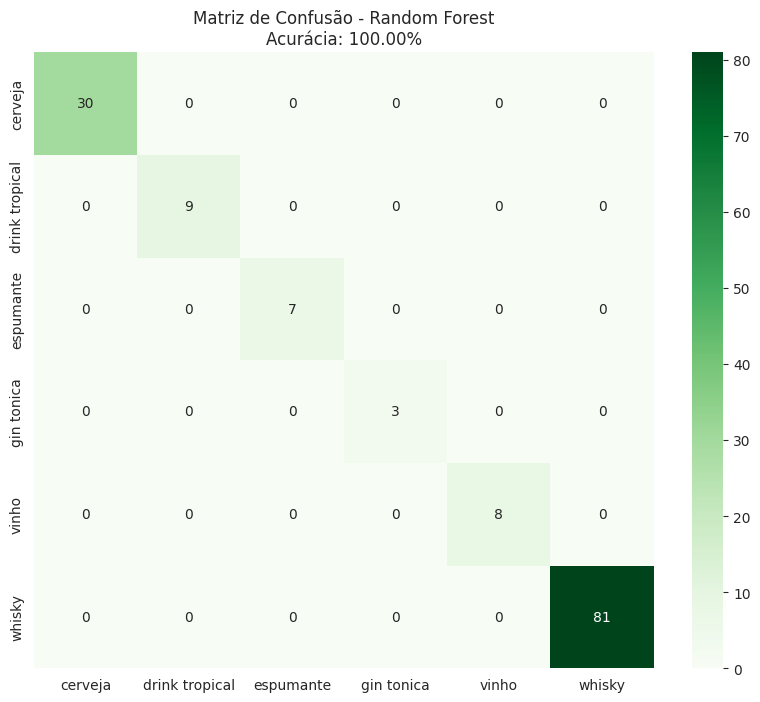

          feature  importance
0           humor    0.395848
3         valence    0.172558
2          energy    0.170805
4    danceability    0.106279
5    acousticness    0.081557
1  estilo_musical    0.072953


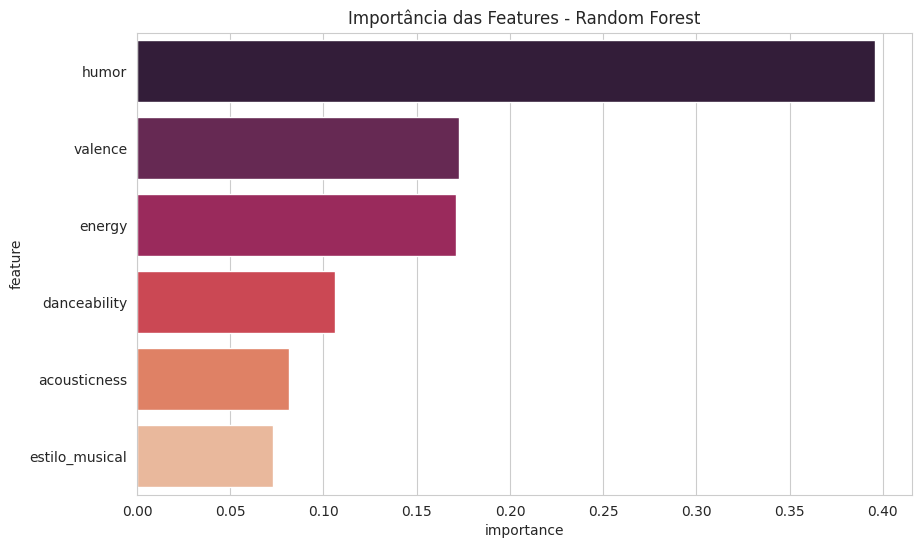

In [29]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final, target_names=le_bebida.classes_))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_bebida.classes_,
            yticklabels=le_bebida.classes_)
plt.title(f'Matriz de Confusão - {melhor_nome}\nAcurácia: {melhor_acc:.2%}')
plt.savefig('matriz_confusao_spotify.png', dpi=300, bbox_inches='tight')
plt.show()

if melhor_nome == "Random Forest":
    feature_names = ['humor', 'estilo_musical', 'energy', 'valence', 'danceability', 'acousticness']
    importances = melhor_modelo.feature_importances_
    feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    print(feat_imp_df)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='rocket')
    plt.title('Importância das Features - Random Forest')
    plt.savefig('feature_importance_spotify.png', dpi=300, bbox_inches='tight')
    plt.show()